# Joke Scorer Notebook
In this notebook we will attempt to develop and fine-tuen the joke scoring module of our network

## Import dependencies
Including loading any relevant packages and tools that we need

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import sys
sys.path.append('../scripts')

from textblob import TextBlob
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda, Dropout, LSTM
from keras.backend import mean
from keras.utils import to_categorical
from keras import optimizers, initializers
from sklearn import metrics
from keras import backend as K

from load_glove_embeddings import load_glove_embeddings

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Ryan
[nltk_data]     Jenkinson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ryan
[nltk_data]     Jenkinson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
word2index, embedding_matrix = load_glove_embeddings('C:/Users/Ryan Jenkinson/Documents/Uni/UCL/Statistical NLP/Coursework 2/nlp-jcag/Local Folder/GloVe/glove.6B.300d.txt', embedding_dim=300)

## Let's get stuck in

In [4]:
def preprocess(words, to_lowercase=True, remove_punctuation=True, remove_digits=True, 
               remove_odd_chars=True, remove_stopwords=True, stem=False, spell_check=False,
               lemmatize=False):
    
    if to_lowercase:
        words = [w.lower() for w in words]
    
    if remove_punctuation:
        words = [w for w in words if not (re.match(r'^\W+$', w) != None)]
    
    if remove_digits:
        words = [w for w in words if not w.replace('.','',1).isdigit()]

    if remove_odd_chars:
        words = [re.sub(r'[^a-zA-Z0-9_]','', w) for w in words]
    
    if remove_stopwords:
        sw = set(nltk.corpus.stopwords.words("english"))
        words = [w for w in words if not w in sw]

    if spell_check:
        words = [str(TextBlob(w).correct()) for w in words]
     
    if stem:
        porter = nltk.PorterStemmer()
        words = [porter.stem(w) for w in words]

    if lemmatize:
        wordnet = nltk.WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
        
    return words

def lookup_index(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d:
            if w in word2index.keys():
                indices.append(word2index[w])
            else:
                indices.append(word2index['unk'])
        output_matrix.append(indices)
    return output_matrix

In [127]:
df = pd.read_csv('../../Local Folder/data/processed_data/combined_jokes_CLEAN.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,body,id,score,title
0,0,0,[removed],7mze5,0,Why do emo kids always have the latest technol...
1,1,1,[removed],7po0g,0,Never judge a book by it's cover.....
2,2,2,[removed],7po6t,0,"I try to avoid buying into this ""Americans are..."
3,3,3,[removed],7q1d2,0,Why did the condom fly across the room?
4,4,4,[removed],7qbwl,8,Oddly addictive: some of the absolute worst jo...


In [6]:
df['class'] = [0 if df.score[i] <= 3 \
               else 1 if (df.score[i] > 3 and df.score[i] <= 50) \
               else 2 if (df.score[i] > 50 and df.score[i] <= 200) \
               else 3 for i in range(df.shape[0])]

In [12]:
df['class'] = [0 if df.score[i] <= 2 \
               else 1 for i in range(df.shape[0])]

In [128]:
# Look at the distribution of jokes between a maximum and minimum score
min_score = 50
max_score = 2000
df = df[(min_score <= df["score"]) & (df["score"] <= max_score)]

In [129]:
map_score_range = [200,250] # This will define where we start thresholding our scores and using our mapping
temp_df = df[(map_score_range[0] <= df["score"])] #& (df["score"] <= max_score)]

# Map range using linear interpolation
temp_df["score"] = (map_score_range[0] + (map_score_range[1] - map_score_range[0])*
                    ((temp_df["score"] - 200) / (max_score - 200))).astype('int') 

# Combine the dataframe with jokes <= map_score_range[0] with the temp_df, sample them to "shuffle them" and reset index
df = pd.concat([df.drop(temp_df.index),temp_df]).sample(frac=1).reset_index(drop=True)

c:\users\ryan jenkinson\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
df.head()

,Unnamed: 0,Unnamed: 0.1,body,id,score,title
0,247858,255975,"Nevermind, I'm done.",30luq7,72,Man with premature ejaculation seeks understan...
1,243385,251370,"His mom kept telling him to do his homework, ""...",2yq5ud,85,Why did Johnny fail his programming class?
2,449780,467789,"So I took them to the fish market and said ""Sh...",786z43,200,I couldn't afford to take the kids to SeaWorld...
3,9166,9218,"A man inserted an 'ad' in the classifieds: ""Wi...",4z3nwl,74,"A man inserted an 'ad' in the classifieds: ""Wi..."
4,304948,314830,"You don't need shoes to run, but it fucking he...",3optj3,89,I hate it when people tell me I don't need alc...


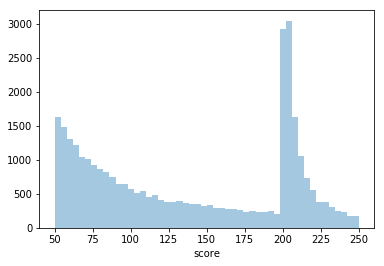

In [131]:
sns.distplot(df['score'], bins=50, kde=False)

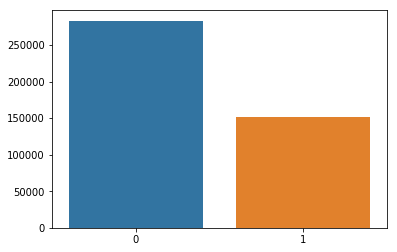

In [14]:
class_counts = df['class'].value_counts()
sns.barplot(class_counts.index, class_counts.values)

In [27]:
df_train = pd.concat([
    df[df['class'] == 0].sample(5000),
    df[df['class'] == 1].sample(7500),
]).sample(frac=1).reset_index()

df_test = pd.concat([
    df[df['class'] == 0].sample(1000),
    df[df['class'] == 1].sample(1000),
]).sample(frac=1).reset_index()

In [79]:
df.head()

,Unnamed: 0,Unnamed: 0.1,body,id,score,title
0,99979,103353,"Don't worry, I like you.",5tb1oc,37,I only lie to people I don't like.
1,97961,101224,[deleted],5wneo2,205,I was walking my dog yesterday..
2,18856,19202,"Honestly, I have no idea. It's still an antijo...",50yhkp,14,What do you call an anti-joke that makes it to...
3,414128,429395,Social security checks,6qhhve,164,2000's kids won't get this
4,114607,118594,[deleted],5z3jm6,40,"My Grandpa said, ""Your generation relies too m..."


In [132]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,2:].drop(columns='score')
y = df['score']
df_train, df_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [133]:
def transform_data(df):
    # Create the documents
    docs = [str(df.title[i]) + ' ' + str(df.body[i]) for i in range(df.shape[0])]
    # Clean documents via preprocessing
    docs_cleaned = [preprocess(words.split()) for words in docs]
    # Encode documents via GloVe
    docs_encoded = lookup_index(docs_cleaned)
    # Pad to maximum length of the jokes. In our clean dataset we thresholded setup at 50 and punchline at 10 -> maxlen=60
    docs_padded = pad_sequences(docs_encoded, maxlen=60, padding='post')
    
    return docs_padded

In [134]:
X_train = transform_data(df_train)
X_test = transform_data(df_test)

In [152]:
# Clear session to avoid memory issues
K.clear_session()

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=60,
                            weights=[embedding_matrix], 
                            trainable=False,
                            mask_zero=True, #Set to True to avoid adding it in a mean
                            name='embedding_layer')

model = Sequential()
model.add(embedding_layer)
#model.add(Lambda(lambda x: mean(x, axis=1)))
# model.add(Flatten())
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(rate=0.25))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(rate=0.25))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(rate=0.25))
# model.add(Dense(128, activation='relu'))


model.add(LSTM(1024))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [153]:
def precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [154]:
adam = optimizers.adam(lr=0.01)
model.compile(optimizer=adam, loss='mean_squared_error') #, precision, recall, f1_score])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 60, 300)           120000300 
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              5427200   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total para

In [156]:
model.fit(X_train, y_train,validation_split=0.3, batch_size=64, epochs=20)

Train on 18382 samples, validate on 7878 samples
Epoch 1/20
18382/18382 [==============================] - 1548s 84ms/step - loss: 4630.4083 - val_loss: 4462.1070
Epoch 2/20
18382/18382 [==============================] - 1554s 85ms/step - loss: 4207.8676 - val_loss: 3952.9017
Epoch 3/20
18382/18382 [==============================] - 1536s 84ms/step - loss: 4089.0499 - val_loss: 4041.4050
Epoch 4/20
18382/18382 [==============================] - 1539s 84ms/step - loss: 4038.4384 - val_loss: 4033.1253
Epoch 5/20
18382/18382 [==============================] - 1541s 84ms/step - loss: 3998.0256 - val_loss: 4250.2700
Epoch 6/20
18382/18382 [==============================] - 1537s 84ms/step - loss: 3995.7922 - val_loss: 4010.8459
Epoch 7/20
18382/18382 [==============================] - 1537s 84ms/step - loss: 3983.8408 - val_loss: 4090.6386
Epoch 8/20
18382/18382 [==============================] - 1543s 84ms/step - loss: 3931.3999 - val_loss: 4017.7211
Epoch 9/20
18382/18382 [===============

In [157]:
y_preds = model.predict(X_test)

In [158]:
y_preds.squeeze()

array([155.0667 , 148.90782, 160.01671, ..., 149.23553, 136.79855,
       154.49553], dtype=float32)

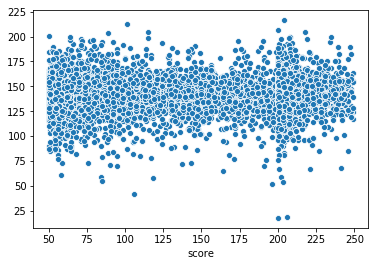

In [159]:
sns.scatterplot(x=y_test,y=y_preds.squeeze())

Text(0.5, 24.0, 'Predicted label')

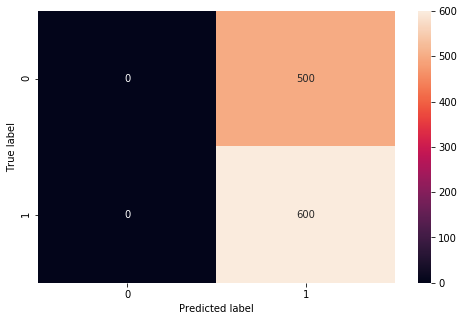

In [159]:
y_test = df_test['class']
y_pred = model.predict_classes(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True,fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')